# Exp009: Adaptive training data generation
The goal is three-fold: Generate good adversarial examples
1. based on frequent unigrams and bigrams in positive text
2. based on maximum scoring token in classification
3. reclassfied positive examples

In [36]:
from tqdm import tqdm
import pandas as pd
import importlib
import re
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

import sys
sys.path.append('../source')
import models
import random
import data
import helpers
import api

#importlib.reload(models)

Load augmented EGP dataset

In [3]:
egp_examples = pd.read_json("../data/egp_examples.json")

Load corpora to test classifier on

In [4]:
sents = data.get_mixed_sentences(20000)

encoded_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

Shuffling sentences...


In [5]:
def probe_model(model, probes):
    encoded_input = models.bert_tokenizer(probes, return_tensors='pt', max_length=64, padding='max_length', truncation=True).to(models.device)
    with torch.no_grad():
        values, indices = model(encoded_input['input_ids'], encoded_input['attention_mask'], diagnose=False)
    tokens = [models.bert_tokenizer.convert_ids_to_tokens(ids) for ids in encoded_input['input_ids']]
    max_tokens = [token[indices[i]] for i, token in enumerate(tokens)]
    return values.cpu(), max_tokens
    
def probe_model_from_loader(model, dataloader, n_batches=3):
    model.eval()
    all_values = []
    all_max_tokens = []
    batches = 0
    
    with torch.no_grad():
        for input_ids, attention_mask in tqdm(dataloader):
            batches += 1
            if batches > n_batches: break
            tokens = [models.bert_tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]
            input_ids, attention_mask = input_ids.to(models.device), attention_mask.to(models.device)
            
            values, indices = model(input_ids, attention_mask)
            max_tokens = [tokens[j][idx] if idx < len(tokens[j]) else '[PAD]' for j, idx in enumerate(indices.cpu().tolist())]

            all_values.extend(values.cpu().tolist())
            all_max_tokens.extend(max_tokens)
    return all_values, all_max_tokens

Sample a random EGP rule and create dataset and classifier

In [43]:
rule = egp_examples[egp_examples['type'] == 'USE'].sample(1).iloc[0]
print(f"{rule['type']}: {rule['Can-do statement']}")
print(rule['Example'])
positive = rule['augmented_examples']
negative = rule['augmented_negative_examples']
others = [example for sublist in egp_examples.loc[egp_examples['#'] != rule['#'], 'augmented_examples'].to_list() for example in sublist]
print(random.sample(positive, 5))
print(random.sample(negative, 5))

USE: Can use question forms to ask rhetorical questions.
[writing about fashion] Are we becoming shallow? 

Why is technology taking over our lives? 

Why am I explaining all this? The only reason is that I want to show that young people are interested in sports.
['Can technology ever replace genuine human connection?', 'Why are we letting fear hold us back from pursuing our dreams?', 'Why are we so quick to judge others?', 'Why do we keep repeating the same mistakes?', 'Why are we allowing ourselves to be controlled by societal pressures and expectations?']
['We truly nourish our minds and bodies with healthy choices.', 'Are we always destined to repeat history, or not?', 'Can we escape the constraints of societal norms, or not?', 'We believe that success is solely determined by wealth and status.', 'We take the time to understand different perspectives.']


Train a fresh classifier

In [44]:
classifier = models.RuleDetector(models.bert_encoder)
dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64) 
train_dataloader, val_dataloader = data.get_loaders(dataset)
optimizer, accuracy = models.train(classifier, train_dataloader, val_dataloader, num_epochs=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Training loss: 0.4716322553157806
Accuracy: 0.94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 19.90it/s]


Training loss: 0.25856154710054396
Accuracy: 0.95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 19.84it/s]


Training loss: 0.18339216560125352
Accuracy: 0.96


Some more systematic evaluation of accuracy

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
accuracies = {}
num_rules = 100
rules = egp_examples.sample(num_rules)
for idx, rule in rules.iterrows():
    positive = rule['augmented_examples']
    negative = rule['augmented_negative_examples']
    others = [example for sublist in egp_examples.loc[egp_examples['#'] != rule['#'], 'augmented_examples'].to_list() for example in sublist]

    classifier = models.RuleDetector(models.bert_encoder)
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    optimizer, accuracy = models.train(classifier, train_dataloader, val_dataloader)
    accuracies[idx] = accuracy
sns.set_style("whitegrid")
sns.histplot(accuracies.values(), bins=10, kde=True, legend=False, color="skyblue", edgecolor='black', alpha=0.7)
plt.ylabel(f"Number of rules / {len(accuracies)}")
plt.xlabel("Validation Accuracy")
plt.title("Distribution of Rule Detection Accuracies")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.show()

In [43]:
np.mean(list(accuracies.values()))

0.9436470588235293

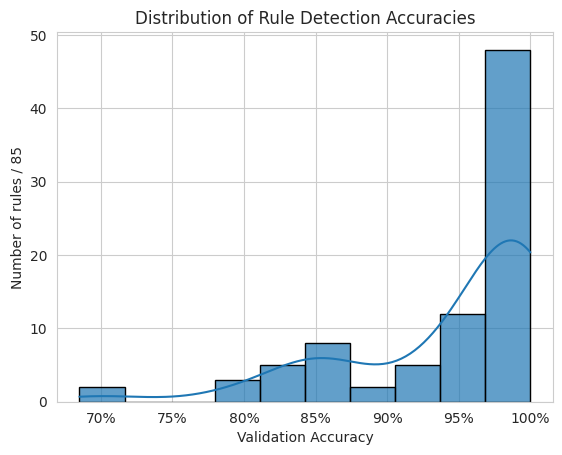

In [34]:
# Result

Test the trained model

Start with training example and random negative

In [45]:
probe_model(classifier, random.sample(positive, 1))

(tensor([0.9779]), ['?'])

In [46]:
probe_model(classifier, random.sample(others, 1))

(tensor([0.0453]), ['[SEP]'])

In [48]:
probe_model(classifier, "Why are you here?")

(tensor([0.7226]), ['?'])

In [13]:
rule['#']

921

Continue with EGP examples

In [50]:
for example in rule['Example'].split("\n\n"):
    print(example)
    score, max_token = probe_model(classifier, example)
    print(f'Score: {score.item()}, Max Token: {max_token[0]}')

[writing about fashion] Are we becoming shallow? 
Score: 0.8571189641952515, Max Token: ?
Why is technology taking over our lives? 
Score: 0.9611295461654663, Max Token: ?
Why am I explaining all this? The only reason is that I want to show that young people are interested in sports.
Score: 0.7406145334243774, Max Token: ?


Apply classifier to corpus

In [42]:
# should stop after n examples have been found
scores, tokens = probe_model_from_loader(classifier, dataloader, n_batches=100)
results = [(score, token, sample) for score, token, sample in zip(scores, tokens, sents[:len(scores)]) if score > 0.5]
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)
for score, token, sample in sorted_results:
    print(f"Sample: {sample}, Score: {score}, Max Token: {token}")

  8%|██████████▋                                                                                                                           | 100/1250 [00:08<01:35, 12.07it/s]

Sample: It was actually founded, in part, by anti-slavery activists!, Score: 0.9973434805870056, Max Token: ,
Sample: In conclusion, putting criminals who are not a danger to society in prison is expensive and, in my opinion, ineffective, both as a deterrent and as a form of rehabilitation., Score: 0.9971936345100403, Max Token: ,
Sample: The new law will work by clarifying people’s wishes around the issue of organ donation and, in turn, increase the rate of consent to donation., Score: 0.996701180934906, Max Token: ,
Sample: Since the registry does not recognize the name of Harriet’s 12-year-old brother, Duncan, either, the two children have, until now, travelled on passports identifying them as Stúlka and Drengur Cardew: Girl and Boy Cardew., Score: 0.9962192177772522, Max Token: ,
Sample: The project has now grown into the Grow2Feed Liberia Fish Farm, with 12 tanks, which, when fully stocked, will each have 5,000 fish – providing up to 200,000 fish per year, serving a community of 1

Find frequent words and create better negative examples

In [17]:
get_bigrams = lambda words: list(zip(words, words[1:]))

unigrams = [example.split(' ') for example in positive]
bigrams = [get_bigrams(example.split(' ')) for example in positive]

unigram_counter = Counter([word for example in unigrams for word in example])
bigram_counter = Counter([" ".join(bigram) for example in bigrams for bigram in example])

top_unigrams = unigram_counter.most_common(3)
top_bigrams = bigram_counter.most_common(3)
top_unigrams + top_bigrams

[('for', 617),
 ('I', 527),
 ('As', 525),
 ('As for', 525),
 ('for myself,', 525),
 ('myself, I', 522)]

In [288]:
negatives = []
for words in top_unigrams + top_bigrams:
    if words[0].lower() == 'the': continue
    if words[1] < 250: continue
    prompt = f'{helpers.get_prompt(rule, n_examples=0, mark_words=False)}Only if possible, create 25 sentences that are NOT examples of this rule but still include "{words[0]}"?'
    print(words[0])
    messages = [ helpers.SYSTEM_MESSAGE, { "role": "user", "content": prompt }]
    response = api.get_openai_chat_completion(messages, max_tokens=512)[0]
    print(response)
    hard_negatives, _  = helpers.parse_response(response)
    negatives += hard_negatives
negatives

have
Sure! Here are 25 sentences that include "have," but do not follow the grammar rule of using the perfect form of "must" to make deductions about the past:

1. I have a lot of homework tonight.
2. They have been friends since childhood.
3. She must have a good reason for canceling the meeting.
4. We have plans to go to the movies tomorrow.
5. The teacher must have already left the classroom.
6. I have never been to Europe.
7. They have decided to get married next summer.
8. We have a meeting scheduled for next week.
9. She must have forgotten about our lunch date.
10. I have my keys, so we can leave now.
11. They have been waiting for over an hour.
12. We have to finalize the project by the end of the week.
13. He must have misplaced his phone somewhere.
14. I have a strong feeling that it will rain today.
15. They have always wanted to visit Australia.
16. We have finished all the tasks on our to-do list.
17. She must have been surprised by the unexpected news.
18. I have heard gr

['I have a lot of homework tonight.',
 'They have been friends since childhood.',
 'She must have a good reason for canceling the meeting.',
 'We have plans to go to the movies tomorrow.',
 'The teacher must have already left the classroom.',
 'I have never been to Europe.',
 'They have decided to get married next summer.',
 'We have a meeting scheduled for next week.',
 'She must have forgotten about our lunch date.',
 'I have my keys, so we can leave now.',
 'They have been waiting for over an hour.',
 'We have to finalize the project by the end of the week.',
 'He must have misplaced his phone somewhere.',
 'I have a strong feeling that it will rain today.',
 'They have always wanted to visit Australia.',
 'We have finished all the tasks on our to-do list.',
 'She must have been surprised by the unexpected news.',
 'I have heard great things about that restaurant.',
 'They have completed the marathon in under four hours.',
 'We have to return the borrowed book to the library.',
 'He

In [289]:
new_positives = random.sample(positive, 2 * len(negatives))
new_negatives = random.sample(negative, len(negatives)) + negatives
print(len(new_negatives))
dataset = data.get_dataset(new_positives, new_negatives, others, models.bert_tokenizer, 64, random_negatives=False) 
train_dataloader, val_dataloader = data.get_loaders(dataset)

150


In [290]:
optimizer = models.train(classifier, train_dataloader, val_dataloader, num_epochs=5, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.30it/s]


Training loss: 0.4287335742264986
Accuracy: 0.8666666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.12it/s]


Training loss: 0.3136064372956753
Accuracy: 0.9166666666666666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.46it/s]


Training loss: 0.26294518262147903
Accuracy: 0.9333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.39it/s]


Training loss: 0.20606214553117752
Accuracy: 0.8666666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.30it/s]


Training loss: 0.2114942129701376
Accuracy: 0.9333333333333333


In [292]:
# TODO: should stop after n examples have been found
scores, tokens = probe_model_from_loader(classifier, dataloader, n_batches=100)
for score, token, sample in zip(scores, tokens, sents[:len(scores)]):
    if score > 0.5:
        print(f"Sample: {sample}, Score: {score}, Max Token: {token}")

 16%|████████████████                                                                                    | 100/625 [00:08<00:43, 12.18it/s]

Sample: You must have been pretty far away from the city., Score: 0.5799371600151062, Max Token: must
Sample: They must have been put there by someone for sharing., Score: 0.5124282240867615, Max Token: must
Sample: You must have been here a long time already., Score: 0.5648075938224792, Max Token: must
Sample: It must have been about ten days ago., Score: 0.6220648884773254, Max Token: must
Sample: It must have been sometime between 12:00 and 1:30 because I was home until almost 12:00 and I just got back at 1:30., Score: 0.9650887250900269, Max Token: must
Sample: It must have been freezing sitting outside, wasn't it?, Score: 0.7344651222229004, Max Token: must


In [224]:
hits

['If you like the room, call the landlord and confirm the information of the room.',
 "Also, if you need alterations to the pants, just bring them in and we'll do them for free.",
 "For those of you who don't have a calculator, get one.",
 'When you get to Waterloo, take the underground to Regents Park.',
 'When his temperature is over 38  C, give him one tablet.',
 'If you hear about something that might happen, then tell me about it.',
 "If you want to lose weight and you can't stop drinking soda, try some diet coke."]

Let's ask GPT4 to classify hits

In [223]:
hits = [sample for score, sample in zip(scores, sents[:len(scores)]) if score > 0.75]

prompt = helpers.get_prompt(rule, n_examples=0, mark_words=False)
prompt += "\nDecide for each of these sentences if they use this rule:\n"
for i, hit in enumerate(hits[:25]):
    prompt += f"{i+1}. {hit}\n"
prompt += "Output format:\n1. [Yes/No]\n2. [Yes/No]\n..."
#print(prompt)
messages = [ helpers.SYSTEM_MESSAGE, { "role": "user", "content": prompt }]
response = api.get_openai_chat_completion(messages, max_tokens=512, model="gpt-4-0125-preview")[0]
print(response)

1. Yes
2. Yes
3. No
4. No
5. No
6. Yes
7. Yes


In [225]:
true_positives_idx = np.array([answer == 'Yes' for num, answer in re.findall(r'(\d+)\.\s(Yes|No)', response)])
true_positives = list(np.array(hits[:25])[true_positives_idx])
print(true_positives)
false_positives = list(np.array(hits[:25])[true_positives_idx == False])
false_positives

['If you like the room, call the landlord and confirm the information of the room.', "Also, if you need alterations to the pants, just bring them in and we'll do them for free.", 'If you hear about something that might happen, then tell me about it.', "If you want to lose weight and you can't stop drinking soda, try some diet coke."]


["For those of you who don't have a calculator, get one.",
 'When you get to Waterloo, take the underground to Regents Park.',
 'When his temperature is over 38  C, give him one tablet.']

In [226]:
new_positives = random.sample(positive, len(true_positives)) + true_positives
print(len(new_positives))
new_negatives = random.sample(negative, len(false_positives)) + false_positives
print(len(new_negatives))
dataset = data.get_dataset(new_positives, new_negatives, others, models.bert_tokenizer, 64, random_negatives=False) 
train_dataloader, val_dataloader = data.get_loaders(dataset)

8
6


In [229]:
optimizer, accuracy = models.train(classifier, train_dataloader, val_dataloader, num_epochs=5, optimizer=optimizer)

  0%|                                                                                                                | 0/1 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'step'

In [320]:
scores, tokens = probe_model_from_loader(classifier, dataloader, n_batches=50)
for score, token, sample in tqdm(zip(scores, tokens, sents[:len(scores)])):
    if score > 0.5:
        print(f"Sample: {sample}, Score: {score}, Max Token: {token}")

  8%|████████                                                                                             | 50/625 [00:04<00:47, 12.16it/s]
3200it [00:00, 2107359.52it/s]

Sample: I am hoping that you will be able to provide me with a reference to help me jump-start my future., Score: 0.9895520806312561, Max Token: able
Sample: Working with my colleagues, we were able to increase the production efficiency by 5 %., Score: 0.9968151450157166, Max Token: able
Sample: I won't be able to sleep well if I drink some tea or coffee., Score: 0.9771876931190491, Max Token: able
Sample: I want a job in which I can use English, I would also like to be able to have some responsibility in my work., Score: 0.9953510761260986, Max Token: able
Sample: Can you tell me when I will be able to get through?, Score: 0.9945673942565918, Max Token: able
Sample: Since you do it so much, I wouldn't be able to sit still that long., Score: 0.9926175475120544, Max Token: able


Let's take the strategy to generate harder minimal examples

In [332]:
pos_tokens = [token for score, token in zip(scores, tokens) if score > 0.5 ]
print(Counter(pos_tokens))
top_token = Counter(pos_tokens).most_common()[0][0]

Counter({'shall': 10})


In [334]:
prompt = f'{helpers.get_prompt(rule, n_examples=0, mark_words=False)}Create 10 sentences that do NOT fulfill that rule but include "{top_token}". Explain for each sentence, why it breaks the rule.'
#print(prompt)
messages = [ helpers.SYSTEM_MESSAGE, { "role": "user", "content": prompt }]
response = api.get_openai_chat_completion(messages, max_tokens=512)[0]
print(response)

1. Shall we go to the movies tonight?
This sentence breaks the rule because it is not seeking advice. It is suggesting or proposing an activity.

2. Shall I pass the salt, please?
This sentence breaks the rule because it is making a polite request rather than seeking advice. The speaker already knows what action to take, and they are simply asking for permission.

3. Shall we dance at the party?
This sentence breaks the rule because it is suggesting an activity rather than seeking advice. It implies making plans or asking for someone's willingness to participate.

4. Shall I tell her the truth?
This sentence breaks the rule because it is seeking permission or seeking confirmation rather than seeking advice. The speaker is already aware of what they should do and is asking for validation.

5. Shall we meet at the cafe tomorrow?
This sentence breaks the rule because it is suggesting a plan or arrangement rather than seeking advice. It implies discussing or deciding on a time and place to

In [324]:
hard_negatives, _  = helpers.parse_response(response)
hard_negatives

["He wasn't able to solve the math problem because it was too difficult for him.",
 "They weren't able to attend the concert due to a scheduling conflict.",
 "I wasn't able to find my keys this morning, so I had to borrow my roommate's.",
 "We weren't able to go on vacation this year because of financial constraints.",
 "She wasn't able to complete the marathon due to an injury.",
 "The company wasn't able to meet its sales target for the quarter.",
 "He wasn't able to reach his goal of losing 10 pounds before the wedding.",
 "They weren't able to secure funding for their startup, so they had to close the business.",
 "I wasn't able to convince my parents to let me study abroad next semester.",
 "We weren't able to attend the party because we had a family commitment.",
 "She wasn't able to fix the leaky faucet despite her best efforts.",
 "They weren't able to book a table at the restaurant because it was fully booked.",
 "He wasn't able to get a promotion at work despite his hard work

In [325]:
new_positives = random.sample(positive, 2 * len(true_positives))
new_negatives = random.sample(negative, len(hard_negatives)) + hard_negatives
print(len(new_negatives))
dataset = data.get_dataset(new_positives, new_negatives, others, models.bert_tokenizer, 64, random_negatives=False)
print(len(dataset))
train_dataloader, val_dataloader = data.get_loaders(dataset)
optimizer = models.train(classifier, train_dataloader, val_dataloader, num_epochs=5, optimizer=optimizer)
scores, tokens = probe_model_from_loader(classifier, dataloader, n_batches=150)
for score, token, sample in tqdm(zip(scores, tokens, sents[:len(scores)])):
    if score > 0.5:
        print(f"Sample: {sample}, Score: {score}, Max Token: {token}")

50
16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Training loss: 0.450713574886322
Accuracy: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.95it/s]


Training loss: 0.3669482469558716
Accuracy: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.11it/s]


Training loss: 0.35650986433029175
Accuracy: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.70it/s]


Training loss: 0.32441043853759766
Accuracy: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.33it/s]


Training loss: 0.23775342106819153
Accuracy: 1.0


 24%|████████████████████████                                                                            | 150/625 [00:12<00:38, 12.26it/s]
9600it [00:00, 1978250.88it/s]

Sample: I am hoping that you will be able to provide me with a reference to help me jump-start my future., Score: 0.8871902227401733, Max Token: able
Sample: Working with my colleagues, we were able to increase the production efficiency by 5 %., Score: 0.961373507976532, Max Token: able
Sample: I won't be able to sleep well if I drink some tea or coffee., Score: 0.6770731806755066, Max Token: able
Sample: I want a job in which I can use English, I would also like to be able to have some responsibility in my work., Score: 0.9517877697944641, Max Token: able
Sample: Can you tell me when I will be able to get through?, Score: 0.9339069128036499, Max Token: able
Sample: Since you do it so much, I wouldn't be able to sit still that long., Score: 0.8930238485336304, Max Token: able
Sample: I wouldn't be able to sleep tonight., Score: 0.6103017926216125, Max Token: able
Sample: You should be able to easily find that for twelve hundred dollars a month., Score: 0.9251460433006287, Max Token: ab

In [ ]:
def get_special_examples(instruction):
    prompt = f'{helpers.get_prompt(rule, n_examples=0, mark_words=False)}Create 25 examples that {instruction}.'
    messages = [ { "role": "user", "content": prompt }]
    response = api.get_openai_chat_completion(messages, max_tokens=512)[0]
    examples, _  = helpers.parse_response(response)
    return examples
extra_examples = get_special_examples('use would have instead.')
print(extra_examples)

In [ ]:
classifier = get_trained_classifer(random.sample(rule['augmented_examples'], 2 * len(extra_examples)),
                                   [], classifier)